# Read and Validate [LORENE](https://lorene.obspm.fr/) Initial Data

## Author(s): Zach Etienne & Leo Werneck

In [1]:
import os, sys
nrpy_dir_path = os.path.join("..")
if nrpy_dir_path not in sys.path:
    sys.path.append(nrpy_dir_path)

if not os.path.exists(os.path.join("lorene_standalone", "Lorene", "Lib", "liblorenef77_g.a")):
    print("""# Error: Lorene hasn't been compiled yet. Please run the following from nrpytutorial/:
cd in_progress  # Make sure you're in the nrpytutorial root directory.
git clone https://bitbucket.org/zach_etienne/lorene_standalone.git
cd lorene_standalone/
# For "Lorene1": wget http://astro.phys.wvu.edu/zetienne/resu.d
# Lorene2 (latest):
wget --no-check-certificate https://ccrgpages.rit.edu/~jfaber/BNSID/Data/simple_polytrope/gam2.5/gam2.5_1.4_1.4/gam2.5_1.4_1.4_hr/gam2.5_1.4_1.4_hr_50/resu_5.000000e+01_1.520000e+00_1.520000e+00.d -O resu.d
cd Lorene/
HOME_LORENE=`pwd` make -j20
""")
    sys.exit(1)
if not os.path.exists(os.path.join("lorene_standalone", "resu.d")):
    print("""# Error: resu.d not found.
# Be sure to go into nrpytutorial
# and run:
cd in_progress/lorene_standalone
# For "Lorene1": wget http://astro.phys.wvu.edu/zetienne/resu.d
# Lorene2 (latest):
wget --no-check-certificate https://ccrgpages.rit.edu/~jfaber/BNSID/Data/simple_polytrope/gam2.5/gam2.5_1.4_1.4/gam2.5_1.4_1.4_hr/gam2.5_1.4_1.4_hr_50/resu_5.000000e+01_1.520000e+00_1.520000e+00.d -O resu.d
""")
    sys.exit(1)

In [2]:
import shutil
import reference_metric as rfm
import NRPy_param_funcs as par
import cmdline_helper as cmd
from outputC import add_to_Cfunction_dict

# Step P1: Create C code output directory:
Ccodesdir = os.path.join("lorene_standalone", "interpolator_new_way")
# Step P1.a: First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Step P1.b: Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P2: Set basic NRPy+ parameters
CoordSystem = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)

enable_rfm_precompute = True
par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")

# Step P3: Set up reference metric quantities
rfm.reference_metric()

# Step P4: Disable FD_functions
FD_functions_enable = False

# STep P5: Disable SIMD
enable_SIMD = False

if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", os.path.join(Ccodesdir, "rfm_files/"))
    
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesdir,"SIMD/"))
    
# Dummy parameter
thismodule = "Lorene_ID"
wavespeed  = par.Cparameters("REAL",thismodule,"wavespeed",1.0)

In [3]:
domain_size     = 64
sinh_width      = 0.2
sinhv2_const_dr = 0.05
SymTP_bScale    = 1.0
CFL_FACTOR      = 0.5

# Step 1.c.i: Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Free parameters related to physical system:
params.wavespeed = 1.0;

// Free parameters related to numerical timestep:
REAL CFL_FACTOR = """+str(CFL_FACTOR)+";\n")

# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

In [4]:
# Step 1.c.iv: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

In [5]:
def add_to_Cfunction_dict_ID_Lorene_ADM_quantities_new_way():
    desc = """(c) 2021 Leo Werneck"""
    includes = ["NRPy_basic_defines.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "ID_Lorene_ADM_quantities"
    
    print("Writing "+name+" function")
    
    params   = """const paramstruct *restrict params,
                  const int i0i1i2[3],const REAL xyz_or_rthph[3],
                  const ID_inputs other_inputs,
                  REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                  REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                  REAL *alpha,
                  REAL *betaU0,REAL *betaU1,REAL *betaU2,
                  REAL *BU0,REAL *BU1,REAL *BU2"""
    body     = """
    // Set useful indices
    const int i0  = i0i1i2[0];
    const int i1  = i0i1i2[1];
    const int i2  = i0i1i2[2];
    const int idx = IDX3S(i0,i1,i2);
    
    // Lapse function alpha
    *alpha = other_inputs.alp[idx];
    
    // Shift vector beta^{i}
    *betaU0 = other_inputs.betax[idx];
    *betaU1 = other_inputs.betay[idx];
    *betaU2 = other_inputs.betaz[idx];
    
    // B^{i}
    *BU0 = 0.0;
    *BU1 = 0.0;
    *BU2 = 0.0;

    // Spatial metric gamma_{ij}
    *gammaDD00 = other_inputs.gxx[idx];
    *gammaDD01 = other_inputs.gxy[idx];
    *gammaDD02 = other_inputs.gxz[idx];
    *gammaDD11 = other_inputs.gyy[idx];
    *gammaDD12 = other_inputs.gyz[idx];
    *gammaDD22 = other_inputs.gzz[idx];

    // Extrinsic curvature K_{ij}
    *KDD00    = other_inputs.kxx[idx];
    *KDD01    = other_inputs.kxy[idx];
    *KDD02    = other_inputs.kxz[idx];
    *KDD11    = other_inputs.kyy[idx];
    *KDD12    = other_inputs.kyz[idx];
    *KDD22    = other_inputs.kzz[idx]; 
"""
    loopopts = "InteriorPoints"
    add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=True)
    
    print("Finished writing "+name+" function")

In [26]:
import ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as atob
atob.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Cartesian","ID_Lorene_ADM_quantities",
                                                            Ccodesdir=Ccodesdir,loopopts="")

def add_to_Cfunction_dict_initial_data_new_way():
    desc     = """(c) 2021 Leo Werneck"""
    includes = ["NRPy_basic_defines.h","NRPy_function_prototypes.h",
                "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h",
                "ID_BSSN__ALL_BUT_LAMBDAs.h",
                "ID_BSSN_lambdas.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "initial_data"
    
    print("Writing "+name+" function")
    
    params   = "const paramstruct *restrict params,REAL *restrict xx[3],ID_inputs other_inputs,REAL *in_gfs"
    body     = r"""
    // Set up BSSN quantities
    ID_BSSN__ALL_BUT_LAMBDAs(params,xx,other_inputs,in_gfs);
    ID_BSSN_lambdas(         params,xx,             in_gfs);
"""
    add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,enableCparameters=False)
    
    print("Finished writing "+name+" function")

Output C function ID_BSSN_lambdas() to file lorene_standalone/interpolator_new_way/ID_BSSN_lambdas.h
Output C function ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs() to file lorene_standalone/interpolator_new_way/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h
Output C function ID_BSSN__ALL_BUT_LAMBDAs() to file lorene_standalone/interpolator_new_way/ID_BSSN__ALL_BUT_LAMBDAs.h


In [7]:
import sympy as sp
import indexedexp as ixp
import grid as gri
import GRFFE.equations as GRFFE

# Metric quantities
DIM     = 3
alpha   = sp.Symbol("other_inputs.alp[IDX3S(i0,i1,i2)]",real=True)
betaU   = ixp.zerorank1()
gammaDD = ixp.zerorank2()
for i in range(DIM):
    betaU[i] = sp.Symbol("other_inputs.beta"+chr(ord('x')+i)+"[IDX3S(i0,i1,i2)]",real=True)
    for j in range(i,DIM):
        gammaDD[i][j] = sp.Symbol("other_inputs.g"+chr(ord('x')+i)+chr(ord('x')+j)+"[IDX3S(i0,i1,i2)]",real=True)
        
# Hydro quantities
rho_b    = gri.register_gridfunctions("AUX","rhob")
u4U      = ixp.register_gridfunctions_for_single_rank1("AUX","u4U",DIM=4)
smallb4U = ixp.register_gridfunctions_for_single_rank1("AUX","smallb4U",DIM=4)
GRFFE.compute_smallbsquared(gammaDD, betaU, alpha, smallb4U)

M_PI,K,Gamma = sp.symbols("M_PI K Gamma",real=True)

# Pressure
P = K * rho_b**Gamma

# Specific internal energy
epsilon = P/rho_b/(Gamma-1)

import GRMHD.equations as GRMHDeqs
GRMHDeqs.compute_GRMHD_T4UU(gammaDD,betaU,alpha, rho_b,P,epsilon,u4U, smallb4U, GRFFE.smallbsquared)

# Compute rho
n4D    = ixp.zerorank1(DIM=4)
n4D[0] = -alpha
rho    = sp.sympify(0)
for mu in range(4):
    for nu in range(4):
        rho += n4D[mu] * n4D[nu] * GRMHDeqs.T4UU[mu][nu]

rhoADM = gri.register_gridfunctions("AUX","rhoADM")

In [8]:
def add_to_Cfunction_dict_set_hydro_quantities_new_way():
    desc = """(c) 2021 Leo Werneck"""
    includes = ["NRPy_basic_defines.h","bin_ns.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "set_hydro_quantities"
    params   = """const paramstruct *restrict params, const ID_inputs other_inputs, REAL *restrict aux_gfs"""
    body     = r"""
    // Set the index
    const int idx = IDX3S(i0,i1,i2);
    
    // Read in needed metric quantities
    const REAL alpL   = other_inputs.alp[idx];
    const REAL gxxL   = other_inputs.gxx[idx];
    const REAL gxyL   = other_inputs.gxy[idx];
    const REAL gxzL   = other_inputs.gxz[idx];
    const REAL gyyL   = other_inputs.gyy[idx];
    const REAL gyzL   = other_inputs.gyz[idx];
    const REAL gzzL   = other_inputs.gzz[idx];
    const REAL betaxL = other_inputs.betax[idx];
    const REAL betayL = other_inputs.betay[idx];
    const REAL betazL = other_inputs.betaz[idx];
    
    // rho_b (don't forget that we need to floor it!)
    const REAL rho_b = std::max(other_inputs.nbar[idx] / other_inputs.rho_b_unit,1e-12);
    
    // Velocities (remember that Lorene gives the Valencia velocity)
    REAL velx = other_inputs.u_euler_x[idx];
    REAL vely = other_inputs.u_euler_y[idx];
    REAL velz = other_inputs.u_euler_z[idx];
    
    // Adapted from IllinoisGRMHD
    REAL one_minus_one_over_alpha_u0_squared = gxxL * velx * velx +
                                           2.0*gxyL * velx * vely +
                                           2.0*gxzL * velx * velz +
                                               gyyL * vely * vely +
                                           2.0*gyzL * vely * velz +
                                               gzzL * velz * velz;

    // Apply velocity limit (W is the Lorentz factor)
    const REAL W_max = 10.0;
    const REAL ONE_MINUS_ONE_OVER_WMAX_SQUARED = 1.0 - 1.0/(W_max*W_max);
    if( one_minus_one_over_alpha_u0_squared > ONE_MINUS_ONE_OVER_WMAX_SQUARED ) {
        REAL correction_fac = sqrt(ONE_MINUS_ONE_OVER_WMAX_SQUARED/one_minus_one_over_alpha_u0_squared);
        velx *= correction_fac;
        vely *= correction_fac;
        velz *= correction_fac;
        one_minus_one_over_alpha_u0_squared = ONE_MINUS_ONE_OVER_WMAX_SQUARED;
        fprintf(stderr,"BAAAD: Initial data with very high velocities!\n");
    }
    
    // Now compute u^{mu}
    const REAL alpha_u0 = 1.0/sqrt(1.0-one_minus_one_over_alpha_u0_squared);
    const REAL u4U0     = alpha_u0/alpL;
    const REAL u4U1     = u4U0 * ( velx * alpL - betaxL );
    const REAL u4U2     = u4U0 * ( vely * alpL - betayL );
    const REAL u4U3     = u4U0 * ( velz * alpL - betazL );
    
    // Set the gridfunctions
    aux_gfs[IDX4ptS(RHOBGF,idx)] = rho_b;
    aux_gfs[IDX4ptS(U4U0GF,idx)] = u4U0;
    aux_gfs[IDX4ptS(U4U1GF,idx)] = u4U1;
    aux_gfs[IDX4ptS(U4U2GF,idx)] = u4U2;
    aux_gfs[IDX4ptS(U4U3GF,idx)] = u4U3;
    
    // TODO: extend to nonzero magnetic fields
    aux_gfs[IDX4ptS(SMALLB4U0GF,idx)] = 0.0;
    aux_gfs[IDX4ptS(SMALLB4U1GF,idx)] = 0.0;
    aux_gfs[IDX4ptS(SMALLB4U2GF,idx)] = 0.0;
    aux_gfs[IDX4ptS(SMALLB4U3GF,idx)] = 0.0;
"""
    loopopts = "AllPoints"
    add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,loopopts=loopopts)
    
    print("Finished writing "+name+" function")

In [9]:
def add_to_Cfunction_dict_Hamiltonian_constraint_source_term_new_way():
    desc = """(c) 2021 Leo Werneck"""
    includes = ["NRPy_basic_defines.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "Hamiltonian_constraint_source_term"
    
    print("Writing "+name+" function")
    
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  const REAL K, const REAL Gamma, ID_inputs other_inputs,
                  REAL *restrict aux_gfs"""
    body     = """
    const int idx        = IDX3S(i0,i1,i2);
    const REAL rhob      = aux_gfs[IDX4ptS(RHOBGF,idx)];
    const REAL u4U0      = aux_gfs[IDX4ptS(U4U0GF,idx)];
    const REAL u4U1      = aux_gfs[IDX4ptS(U4U1GF,idx)];
    const REAL u4U2      = aux_gfs[IDX4ptS(U4U2GF,idx)];
    const REAL u4U3      = aux_gfs[IDX4ptS(U4U3GF,idx)];
    const REAL smallb4U0 = aux_gfs[IDX4ptS(SMALLB4U0GF,idx)];
    const REAL smallb4U1 = aux_gfs[IDX4ptS(SMALLB4U1GF,idx)];
    const REAL smallb4U2 = aux_gfs[IDX4ptS(SMALLB4U2GF,idx)];
    const REAL smallb4U3 = aux_gfs[IDX4ptS(SMALLB4U3GF,idx)];
    """+outputC(rho,gri.gfaccess("aux_gfs", "rhoADM"), "returnstring",
                params="outCverbose=False")
    loopopts = "InteriorPoints"
    add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,loopopts=loopopts)
    
    print("Finished writing "+name+" function")

In [10]:
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

# Now register the Hamiltonian as a gridfunction.
# H = gri.register_gridfunctions("AUX","H")
# Then define the Hamiltonian constraint and output the optimized C code
import BSSN.BSSN_constraints as bssncon
import BSSN.BSSN_stress_energy_source_terms as Bsest
bssncon.BSSN_constraints(add_T4UUmunu_source_terms=False)

# Reset to False to disable rfm_precompute
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False")
rfm.ref_metric__hatted_quantities()

def add_to_Cfunction_dict_Hamiltonian_constraint_no_source_term_new_way():
    desc = """(c) 2021 Leo Werneck"""
    includes = ["NRPy_basic_defines.h"]
    prefunc  = ""
    c_type   = "void"
    name     = "Hamiltonian_constraint_no_source_term"
    
    print("Writing "+name+" function")
    
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  REAL *restrict in_gfs, REAL *restrict aux_gfs"""
    body     = fin.FD_outputC("returnstring",lhrh(lhs=gri.gfaccess("aux_gfs", "H"), rhs=bssncon.H),
                              params="outCverbose=False")
    loopopts = "InteriorPoints,Enable_rfm_precompute"
    add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,loopopts=loopopts)
    
    print("Finished writing "+name+" function")

In [11]:
from outputC import outC_NRPy_basic_defines_h_dict
def generate_supplementary_dict():
    # First register C functions needed by grid

    # Then set up the dictionary entry for grid in NRPy_basic_defines
    supplementary_dict = {}
    supplementary_dict["Lorene_ID"] = r"""
typedef struct of_ID_inputs {
    // This struct is used to store Lorene
    // initial data in Cartesian basis
    REAL *alp,*betax,*betay,*betaz;
    REAL *gxx,*gxy,*gxz,*gyy,*gyz,*gzz;
    REAL *kxx,*kxy,*kxz,*kyy,*kyz,*kzz;
    REAL *nbar, *u_euler_x,*u_euler_y,*u_euler_z;
    REAL rho_b_unit;
} ID_inputs;
"""
    return supplementary_dict

In [12]:
def add_to_Cfunction_dict_main__interpolator_new_way():
    print("Writing main function")
    desc = """
(c) 2009 Erik Schnetter
(c) 2010 Frank Loeffler
Edits by Z Etienne 2021
"""

    includes = ["<cstdio>", "<cstring>", "<vector>", "<ios>", "<iostream>",
                "assert.h", "stdlib.h", "bin_ns.h", "unites.h",
                "NRPy_basic_defines.h","NRPy_function_prototypes.h"]

    prefunc = r"""
using namespace std;

// define namespace here for old versions of Lorene that don't do so
namespace Lorene {}
using namespace Lorene;
"""

    c_type = "int"
    name = "main"
    
    print("Writing "+name+" function")
    
    params = "int argc, const char *argv[]"
    body = r"""
  // Step 0: Check correct usage
  if((argc < 9) || (argc > 10)) {
    fprintf(stderr,"Error, incorrect usage. Usage: ./standalone_interpolator [Nx0] [Nx1] [Nx2] [offset_axis] [offset_star_1] [offset_star_2] [Gamma] [filename (resu.d)] [(optional) initial shift (zero or lorene)]\n");
    exit(1);
  }

  // Step 0.a: Set up physical constants for converting quantities
  //           from SI units (Lorene) to Geometrized units (NRPy)
  // Be aware: these are the constants Lorene uses. They do differ from other
  // conventions, but they gave the best results in some tests.
  double const c_light  = Unites::c_si;      // speed of light [m/s]
  double const nuc_dens = Unites::rhonuc_si; // Nuclear density as used in Lorene units [kg/m^3]
  double const G_grav   = Unites::g_si;      // gravitational constant [m^3/kg/s^2]
  double const M_sun    = Unites::msol_si;   // solar mass [kg]

  // Step 0.b: Geometrized units in terms of SI units:
  // (These are derived from M = M_sun, c = G = 1,
  // and using 1/M_sun for the magnetic field)
  double const geomM = M_sun;
  double const geomL = geomM * G_grav / pow(c_light,2);
  double const geomT = geomL / c_light;

  // Step 0.c: Other quantities
  double const coord_unit = geomL / 1.0e+3;       // from km (~1.477)
  double const rho_b_unit = geomM / pow(geomL,3); // from kg/m^3

  // Step 0.d: Set initial shift from user input or default to zero
  char initial_shift[200];
  if( argc == 10 ) {
    sprintf(initial_shift,"%s",argv[9]);
  }
  else {
    sprintf(initial_shift,"%s","zero");
  }

  // Step 0.f: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

  int offset_index;
  REAL offset_star1_xyz[3] = {0,0,0};
  REAL offset_star2_xyz[3] = {0,0,0};
  char offset_axis[10];
  sprintf(offset_axis,"%s",argv[4]);
  
  if( !strcmp(offset_axis,"x") ) {
    offset_index = 0;
    printf("Found x\n");
  }
  else if( !strcmp(offset_axis,"y") ) {
    printf("Found y\n");
    offset_index = 1;
  }
  else if( !strcmp(offset_axis,"z") ) {
    printf("Found z\n");
    offset_index = 2;
  }
  else {
    printf("Found error\n");
    fprintf(stderr,"Error: unsupported offset axis: %s. Supported options are: x, y, and z\n");
    exit(1);
  }
  offset_star1_xyz[offset_index] = strtod(argv[5],NULL) / coord_unit;
  offset_star2_xyz[offset_index] = strtod(argv[6],NULL) / coord_unit;

  printf("Beginning analysis of Lorene initial data.\n");
  printf("Grid #1 will be centered at (x,y,z) = (%g,%g,%g)\n",offset_star1_xyz[0],offset_star1_xyz[1],offset_star1_xyz[2]);
  printf("Grid #2 will be centered at (x,y,z) = (%g,%g,%g)\n",offset_star2_xyz[0],offset_star2_xyz[1],offset_star2_xyz[2]);
  printf("Grid #3 will be centered at (x,y,z) = (0,0,0)\n");

  const int ngrids = 3;
  for(int n_grid=1;n_grid<=ngrids;n_grid++) {

    printf("Beginning analysis of Grid #%d\n",n_grid);

    // Step 0.e: Set up NRPy parameter struct
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0.g: Set free parameters, overwriting Cparameters defaults
    //           by hand or with command-line input, as desired.
#include "free_parameters.h"

    if(n_grid == 1) {
      params.Cart_originx = offset_star1_xyz[0];
      params.Cart_originy = offset_star1_xyz[1];
      params.Cart_originz = offset_star1_xyz[2];
      params.RMAX         = 24;
    }
    else if(n_grid == 2) {
      params.Cart_originx = offset_star2_xyz[0];
      params.Cart_originy = offset_star2_xyz[1];
      params.Cart_originz = offset_star2_xyz[2];
      params.RMAX         = 24;
    }
  
    // Step 0.h: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];

    // Step 0.i: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //           params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //           chosen (non-Eigen) CoordSystem.
    int EigenCoord = 1;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0.j: Set all C parameters "blah" for params.blah, including
    //           Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0.l: Allocate memory for initial data gridfunctions on NRPy grid
    REAL *id_gfs  = (REAL *)malloc(NUM_EVOL_GFS*Nxx_plus_2NGHOSTS_tot*sizeof(REAL));
    REAL *aux_gfs = (REAL *)malloc(NUM_AUX_GFS*Nxx_plus_2NGHOSTS_tot*sizeof(REAL));

    // Step 0.m: Set up precomputed reference metric arrays
    // Step 0.m.i: Allocate space for precomputed reference metric arrays.
    rfm_struct rfmstruct;
    rfm_precompute_rfmstruct_malloc(&params, &rfmstruct);

    // Step 0.m.ii: Define precomputed reference metric arrays.
    {
#include "set_Cparameters-nopointer.h"
      rfm_precompute_rfmstruct_define(&params, xx, &rfmstruct);
    }

    // LORENE COORDINATES, != NRPy COORDINATES
    vector<double> x_Lorene(Nxx_plus_2NGHOSTS_tot);
    vector<double> y_Lorene(Nxx_plus_2NGHOSTS_tot);
    vector<double> z_Lorene(Nxx_plus_2NGHOSTS_tot);

#pragma omp parallel for
    for(int i2=0;i2<Nxx_plus_2NGHOSTS2;i2++) {
      for(int i1=0;i1<Nxx_plus_2NGHOSTS1;i1++) {
        for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
          const int idx = IDX3S(i0,i1,i2);
          REAL xCart[3];
          xx_to_Cart(&params,xx,i0,i1,i2,xCart);
          x_Lorene[idx] = xCart[0] * coord_unit;
          y_Lorene[idx] = xCart[1] * coord_unit;
          z_Lorene[idx] = xCart[2] * coord_unit;
        }
      }
    }

    // --------------------------------------------------------------
    //   CHECKING FILE NAME EXISTENCE
    // --------------------------------------------------------------
    FILE *file;
    char filename[100];
    sprintf(filename,"%s",argv[8]);
    if ((file = fopen(filename, "r")) != NULL)
      fclose(file);
    else {
      fprintf(stderr,
              "File \"%s\" does not exist. ABORTING\n", filename);
      exit(1);
    }

    printf( "Reading from file \"%s\"\n", filename);

    
    Bin_NS bin_ns(Nxx_plus_2NGHOSTS_tot, &x_Lorene[0], &y_Lorene[0], &z_Lorene[0], filename);

    printf( "omega [rad/s]:       %g\n", bin_ns.omega);
    printf( "dist [km]:           %g\n", bin_ns.dist);
    printf( "dist_mass [km]:      %g\n", bin_ns.dist_mass);
    printf( "mass1_b [M_sun]:     %g\n", bin_ns.mass1_b);
    printf( "mass2_b [M_sun]:     %g\n", bin_ns.mass2_b);
    printf( "mass_ADM [M_sun]:    %g\n", bin_ns.mass_adm);
    printf( "L_tot [G M_sun^2/c]: %g\n", bin_ns.angu_mom);
    printf( "rad1_x_comp [km]:    %g\n", bin_ns.rad1_x_comp);
    printf( "rad1_y [km]:         %g\n", bin_ns.rad1_y);
    printf( "rad1_z [km]:         %g\n", bin_ns.rad1_z);
    printf( "rad1_x_opp [km]:     %g\n", bin_ns.rad1_x_opp);
    printf( "rad2_x_comp [km]:    %g\n", bin_ns.rad2_x_comp);
    printf( "rad2_y [km]:         %g\n", bin_ns.rad2_y);
    printf( "rad2_z [km]:         %g\n", bin_ns.rad2_z);
    printf( "rad2_x_opp [km]:     %g\n", bin_ns.rad2_x_opp);
    double K = bin_ns.kappa_poly1 * pow((pow(c_light, 6.0) /
                                         ( pow(G_grav, 3.0) * M_sun * M_sun *
                                           nuc_dens )),bin_ns.gamma_poly1-1.);
    printf( "K [ET unit]:         %.15g\n", K);
    double Gamma = strtod(argv[7],NULL);
    printf( "Gamma:               %g\n", Gamma);

    assert(bin_ns.np == Nxx_plus_2NGHOSTS_tot);

    printf("Filling in NRPy grid points\n");

    // Set up the initial data struct
    ID_inputs other_inputs;
    other_inputs.alp        = bin_ns.nnn;
    other_inputs.gxx        = bin_ns.g_xx;
    other_inputs.gxy        = bin_ns.g_xy;
    other_inputs.gxz        = bin_ns.g_xz;
    other_inputs.gyy        = bin_ns.g_yy;
    other_inputs.gyz        = bin_ns.g_yz;
    other_inputs.gzz        = bin_ns.g_zz;
    other_inputs.kxx        = bin_ns.k_xx;
    other_inputs.kxy        = bin_ns.k_xy;
    other_inputs.kxz        = bin_ns.k_xz;
    other_inputs.kyy        = bin_ns.k_yy;
    other_inputs.kyz        = bin_ns.k_yz;
    other_inputs.kzz        = bin_ns.k_zz;
    other_inputs.betax      = bin_ns.beta_x;
    other_inputs.betay      = bin_ns.beta_y;
    other_inputs.betaz      = bin_ns.beta_z;
    other_inputs.u_euler_x  = bin_ns.u_euler_x;
    other_inputs.u_euler_y  = bin_ns.u_euler_y;
    other_inputs.u_euler_z  = bin_ns.u_euler_z;
    other_inputs.nbar       = bin_ns.nbar;
    other_inputs.rho_b_unit = rho_b_unit;

    // Change units in K_{ij} and set beta^{i} to zero, if requested by the user
#pragma omp parallel for
    for(int i=0;i<Nxx_plus_2NGHOSTS_tot;i++) {
      other_inputs.kxx[i] *= coord_unit;
      other_inputs.kxy[i] *= coord_unit;
      other_inputs.kxz[i] *= coord_unit;
      other_inputs.kyy[i] *= coord_unit;
      other_inputs.kyz[i] *= coord_unit;
      other_inputs.kzz[i] *= coord_unit;
      if(strcmp(initial_shift,"zero")) {
        other_inputs.betax[i] = 0.0;
        other_inputs.betay[i] = 0.0;
        other_inputs.betaz[i] = 0.0;
      }
    }

    // Compute BSSN quantities from ADM Cartesian quantities
    printf("Computing BSSN quantities...\n");
    initial_data(&params,xx,other_inputs,id_gfs);

    // Set hydro quantities
    printf("Setting hydro quantities...\n");
    set_hydro_quantities(&params,other_inputs,aux_gfs);

    // Compute Hamiltonian constraint violation
    printf("Computing costraint violations...\n");
    Hamiltonian_constraint_no_source_term(&rfmstruct,&params,id_gfs,aux_gfs);
    Hamiltonian_constraint_source_term(&rfmstruct,&params,K,Gamma,other_inputs,aux_gfs);

    {
      printf("Outputting 1D data...\n");
      // 1D data
      char filename[256];
      sprintf(filename,"initial_data_grid_%d.x.asc",n_grid);
      FILE* fp = fopen(filename,"w");
      const int i1_out = Nxx_plus_2NGHOSTS1/2;
      int i2_out       = NGHOSTS;
      for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
        REAL xCart[3];
        xx_to_Cart(&params,xx,i0,i1_out,i2_out,xCart);

        const int idx = IDX3S(i0,i1_out,i2_out);
        const REAL H = aux_gfs[IDX4ptS(HGF,idx)] - 16.0*M_PI*aux_gfs[IDX4ptS(RHOADMGF,idx)];
        fprintf(fp,"%e %e\n",xCart[0],H);
      }
      i2_out = Nxx_plus_2NGHOSTS2/2;
      for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++) {
        REAL xCart[3];
        xx_to_Cart(&params,xx,i0,i1_out,i2_out,xCart);

        const int idx = IDX3S(i0,i1_out,i2_out);
        const REAL H = aux_gfs[IDX4ptS(HGF,idx)] - 16.0*M_PI*aux_gfs[IDX4ptS(RHOADMGF,idx)];
        fprintf(fp,"%e %e\n",xCart[0],H);
      }
      fclose(fp);
    }
    {
      printf("Outputting 2D data...\n");
      // 2D data
      char filename[256];
      sprintf(filename,"initial_data_grid_%d.xy.asc",n_grid);
      FILE* fp = fopen(filename,"w");
      const int i1_out = Nxx_plus_2NGHOSTS1/2;
      for(int i2=0;i2<Nxx_plus_2NGHOSTS2;i2++) {
        for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++) {
          REAL xCart[3];
          xx_to_Cart(&params,xx,i0,i1_out,i2,xCart);
          const int idx = IDX3S(i0,i1_out,i2);
          fprintf(fp,"%e %e %e\n",xCart[0],xCart[1],aux_gfs[IDX4ptS(RHOBGF,idx)]);
        }
        fprintf(fp,"\n");
      }
      fclose(fp);
    }

    for(int i=0;i<3;i++) free(xx[i]);
    free(id_gfs);
    free(aux_gfs);

    printf ("Done.\n");
  }

"""
    add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body, enableCparameters=False)
    
    print("Finished writing "+name+" function")

In [13]:
# add all other functions to Cfunction_dict first!
import finite_difference as fin
from outputC import outputC,lhrh

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",4)

function_list = [add_to_Cfunction_dict_ID_Lorene_ADM_quantities_new_way,
                 add_to_Cfunction_dict_set_hydro_quantities_new_way,
                 add_to_Cfunction_dict_initial_data_new_way,
                 add_to_Cfunction_dict_Hamiltonian_constraint_no_source_term_new_way,
                 add_to_Cfunction_dict_Hamiltonian_constraint_source_term_new_way,
                 add_to_Cfunction_dict_main__interpolator_new_way]

def master_func(f):
    f()

# import multiprocess
# with multiprocess.Pool() as pool:
#     pool.map(master_func,function_list)
for function in function_list:
    function()

Writing ID_Lorene_ADM_quantities function
Finished writing ID_Lorene_ADM_quantities function
Finished writing set_hydro_quantities function
Writing initial_data function
Finished writing initial_data function
Writing Hamiltonian_constraint_no_source_term function
Finished writing Hamiltonian_constraint_no_source_term function
Writing Hamiltonian_constraint_source_term function
Finished writing Hamiltonian_constraint_source_term function
Writing main function
Writing main function
Finished writing main function


In [14]:
import outputC as outC

outC.register_C_functions_and_NRPy_basic_defines()  # #define M_PI,  etc.
gri.register_C_functions_and_NRPy_basic_defines()  # #define IDX3S(),  etc.
rfm.register_C_functions_and_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=False)

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if FD_functions_enable:
    fin.output_finite_difference_functions_h(path=Ccodesdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesdir, enable_SIMD=enable_SIMD,
                                    supplemental_dict=generate_supplementary_dict())
outC.construct_NRPy_function_prototypes_h(Ccodesdir)

In [15]:
cmd.new_C_compile(Ccodesdir, "interpolator_new_way",
                  addl_CFLAGS=["-I../Lorene/Export/C++/Include",
#                                "-I/usr/local/Cellar/fftw/3.3.9_1/include",
#                                "-I/usr/local/Cellar/gsl/2.7/include",
                               "-I../Lorene/C++/Include"],
                  addl_libraries=["-L../Lorene/Lib/",
#                                   "-L/usr/local/Cellar/fftw/3.3.9_1/lib",
#                                   "-L/usr/local/Cellar/gsl/2.7/lib",
                                  "-llorene_export", "-llorene",
                                  "-llorenef77", "-lgfortran", "-lfftw3", "-lgsl",
                                  "-lgslcblas", "-llapack", "-lblas"],
                  CC="g++")

(EXEC): Executing `make -j10`...
ld: warning: ld: warning: dylib (/usr/local/Cellar/fftw/3.3.9_1/lib/libfftw3.dylib) was built for newer macOS version (11.2) than being linked (10.16)dylib (/usr/local/Cellar/gsl/2.7/lib/libgslcblas.dylib) was built for newer macOS version (11.0) than being linked (10.16)

ld: warning: dylib (/usr/local/Cellar/gsl/2.7/lib/libgsl.dylib) was built for newer macOS version (11.0) than being linked (10.16)
(BENCH): Finished executing in 4.677836894989014 seconds.
Finished compilation.


In [16]:
os.chdir(Ccodesdir)
cmd.Execute("interpolator_new_way", "128 32 32 x 25 -25 2.5 ../resu.d")
os.chdir(os.path.join("..",".."))

(EXEC): Executing `./interpolator_new_way 128 32 32 x 25 -25 2.5 ../resu.d`...
(BENCH): Finished executing in 277.48651218414307 seconds.


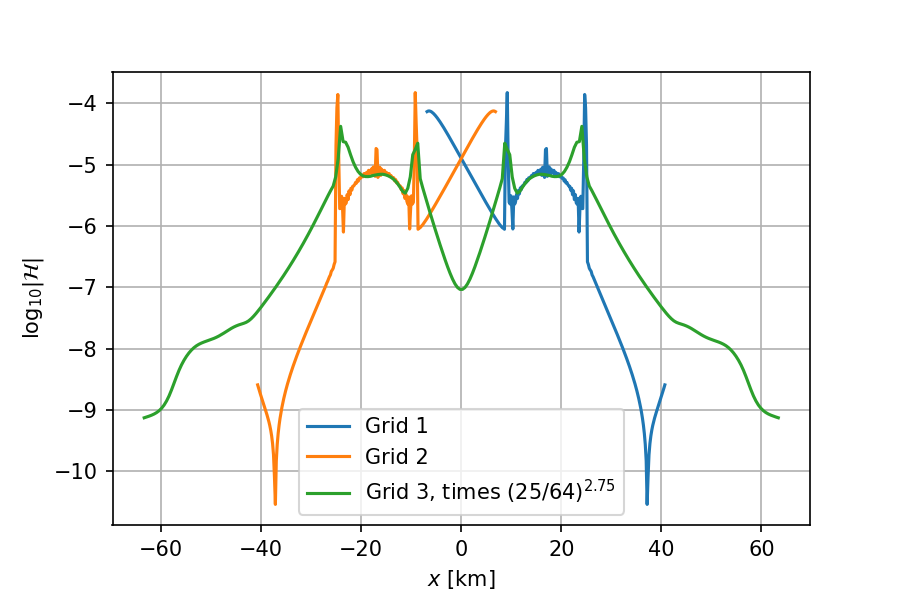

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

data_dir = os.path.join("lorene_standalone","interpolator_new_way")

grid_1_x,grid_1_H = np.loadtxt(os.path.join(data_dir,"initial_data_grid_1.x.asc")).T
grid_2_x,grid_2_H = np.loadtxt(os.path.join(data_dir,"initial_data_grid_2.x.asc")).T
grid_3_x,grid_3_H = np.loadtxt(os.path.join(data_dir,"initial_data_grid_3.x.asc")).T

grid_1_x,grid_1_H = [list(x) for x in zip(*sorted(zip(grid_1_x,grid_1_H), key=lambda pair: pair[0]))]
grid_2_x,grid_2_H = [list(x) for x in zip(*sorted(zip(grid_2_x,grid_2_H), key=lambda pair: pair[0]))]
grid_3_x,grid_3_H = [list(x) for x in zip(*sorted(zip(grid_3_x,grid_3_H), key=lambda pair: pair[0]))]

# Take absolute value
grid_1_H = np.abs(grid_1_H)
grid_2_H = np.abs(grid_2_H)
grid_3_H = np.abs(grid_3_H)

# Apply floor
grid_1_H[grid_1_H<1e-15] = 1e-15
grid_2_H[grid_2_H<1e-15] = 1e-15
grid_3_H[grid_3_H<1e-15] = 1e-15

fig = plt.figure()

plt.xlabel(r"$x$ [km]")
plt.ylabel(r"$\log_{10}\left|\mathcal{H}\right|$")

plt.plot()
plt.plot(grid_1_x,np.log10(grid_1_H),label="Grid 1")
plt.plot(grid_2_x,np.log10(grid_2_H),label="Grid 2")
plt.plot(grid_3_x,np.log10(grid_3_H)+2.75*np.log10(25.0/64.0),label="Grid 3, times $(25/64)^{2.75}$")
plt.legend()
plt.grid()

outfig = "constraint_violations.png"
plt.savefig(outfig,dpi=150,facecolor='white')
plt.close(fig)
Image(outfig)

In [18]:
# from scipy.interpolate import griddata

# grid_1_x,grid_1_y,grid_1_rho = np.loadtxt(os.path.join(data_dir,"initial_data_grid_1.xy.asc")).T

# ncols=3
# fig = plt.figure()

# bound   = 25/1.476625
# pl_xmin = bound*0.5
# pl_xmax = bound*1.5
# pl_ymin = -bound*0.5
# pl_ymax = +bound*0.5
# grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:800j, pl_ymin:pl_ymax:800j]
# points = np.zeros((len(grid_1_x), 2))
# for i in range(len(grid_1_x)):
#     # Zach says: No idea why x and y get flipped...
#     points[i][0] = grid_1_y[i]
#     points[i][1] = grid_1_x[i]

# plot_data = grid_1_rho

# grid = griddata(points, plot_data, (grid_x, grid_y), method='cubic')

# fig,ax = plt.subplots(dpi=300)

# # cbmin = -7
# # cbmax = -1
# cblabel = r"$\rho_{\rm b}$"

# plt.title(r"Density")
# plt.xlabel(r"$x$")
# plt.ylabel(r"$y$")

# im = plt.imshow(grid, extent=(pl_xmin,pl_xmax,pl_ymin,pl_ymax),)
# # im.set_clim(cbmin,cbmax)
# cb = fig.colorbar(im, ax=ax,extend='both')
# cb.set_label(cblabel)

# outfig = "density.png"
# plt.savefig(outfig,dpi=150,facecolor='white')
# plt.close(fig)
# Image(outfig)